# Dataset: Trackster neighborhood approach

Get tracksters from the cone neighbourhood.

Neighbourhood:
- get links from ticlNtuplizer/graph
    - linked_inners: nodes linked to the given tracksters within its cone

Use the features from MLP approach per trackster.
Look at the graph of tracksters, extract information from the neighborhood and perform link prediction.
- convert the tracksters into some latent space and predict a link between them
- use edgeconv or sageconf to add information from the neighbourhood


In [15]:
import uproot
import numpy as np
import awkward as ak

from reco.datasetPU import TracksterGraph, get_event_graph
from reco.data import get_bary_data, get_event_data

# plotting config
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size': 12})
rc('mathtext',**{'default':'regular'})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


ds_name = "CloseByPion200PU"
file_name = f"new_ntuples_15643817_0.root"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"
file_path = f"{raw_dir}/{file_name}"

In [17]:
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_path, pileup=True)

In [18]:
eid = 0
dataset = get_event_graph(
    cluster_data,
    trackster_data,
    assoc_data,
    eid,
    bigT_e_th=10,
    radius=10,
    pileup=True,
)
print("High-energy tracksters:", len(dataset))

ds = dataset[0]

node_index = ds.node_index
pos_index = ds.y >= 0.7
neg_index = ds.y < 0.7

positive = node_index[pos_index].tolist()
negative = node_index[neg_index].tolist()

print("Trackster 0:", len(positive), "/", len(node_index))

High-energy tracksters: 2
Trackster 0: 2 / 3


## Evaluation

In [20]:
from reco.evaluation import model_evaluation
from reco.dummy import DummyPleaser

In [22]:
result = model_evaluation(
    cluster_data,
    trackster_data,
    simtrackster_data,
    assoc_data,
    DummyPleaser(),
    decision_th=0.5,
    radius=15,
    bigT_e_th=10,
    max_events=10,
    reco_eval=False,
    graph=True,
    pileup=True,
)

Event 0:
	clue3d_to_sim:	P: 0.711 R: 0.199 F: 0.469
	target_to_sim:	P: 0.710 R: 0.440 F: 0.633
Event 1:
	No data
Event 2:
	clue3d_to_sim:	P: 0.213 R: 0.303 F: 0.226
	target_to_sim:	P: 0.206 R: 0.330 F: 0.223
Event 3:
	clue3d_to_sim:	P: 0.435 R: 0.706 F: 0.471
	target_to_sim:	P: 0.427 R: 0.852 F: 0.474
Event 4:
	clue3d_to_sim:	P: 0.055 R: 0.500 F: 0.067
	target_to_sim:	P: 0.051 R: 0.678 F: 0.063
Event 5:
	clue3d_to_sim:	P: 0.986 R: 0.243 F: 0.612
	target_to_sim:	P: 0.986 R: 0.341 F: 0.716
Event 6:
	clue3d_to_sim:	P: 1.000 R: 0.857 F: 0.968
	target_to_sim:	P: 1.000 R: 0.922 F: 0.983
Event 7:
	No data
Event 8:
	clue3d_to_sim:	P: 0.847 R: 0.505 F: 0.746
	target_to_sim:	P: 0.842 R: 0.879 F: 0.849
Event 9:
	clue3d_to_sim:	P: 0.999 R: 0.320 F: 0.702
	target_to_sim:	P: 0.996 R: 0.843 F: 0.961
-----
mean clue3d_to_sim:	P: 0.656 R: 0.454 F: 0.532
mean target_to_sim:	P: 0.652 R: 0.661 F: 0.613


In [ ]:
eth_ranges = range(0, 100, 10)
r_ranges = [10, 20, 30, 50, 100]
eth_results = []

max_events = 10

for r in r_ranges:
    _clue3D_F = []
    _target_F = []
    for eth in eth_ranges:
        print(f" --- Radius: {r} | Eth: {eth} ---")
        result = model_evaluation(
            cluster_data,
            trackster_data,
            simtrackster_data,
            assoc_data,
            DummyPleaser(),
            decision_th=0.5,
            radius=r,
            bigT_e_th=eth,
            max_events=max_events,
            reco_eval=False,
            graph=True
        )
        # ignore cases where there is nothing to do
        c3d = np.array(result["clue3d_to_sim"])[:,2]
        tgf = np.array(result["target_to_sim"])[:,2]
        # cmp_idx = c3d != tgf
        # c3d = c3d[cmp_idx] 
        # tgf = tgf[cmp_idx] 
        _clue3D_F.append(np.sum(c3d) / max_events)
        _target_F.append(np.sum(tgf) / max_events)
    eth_results.append(np.array(_target_F) - np.array(_clue3D_F))

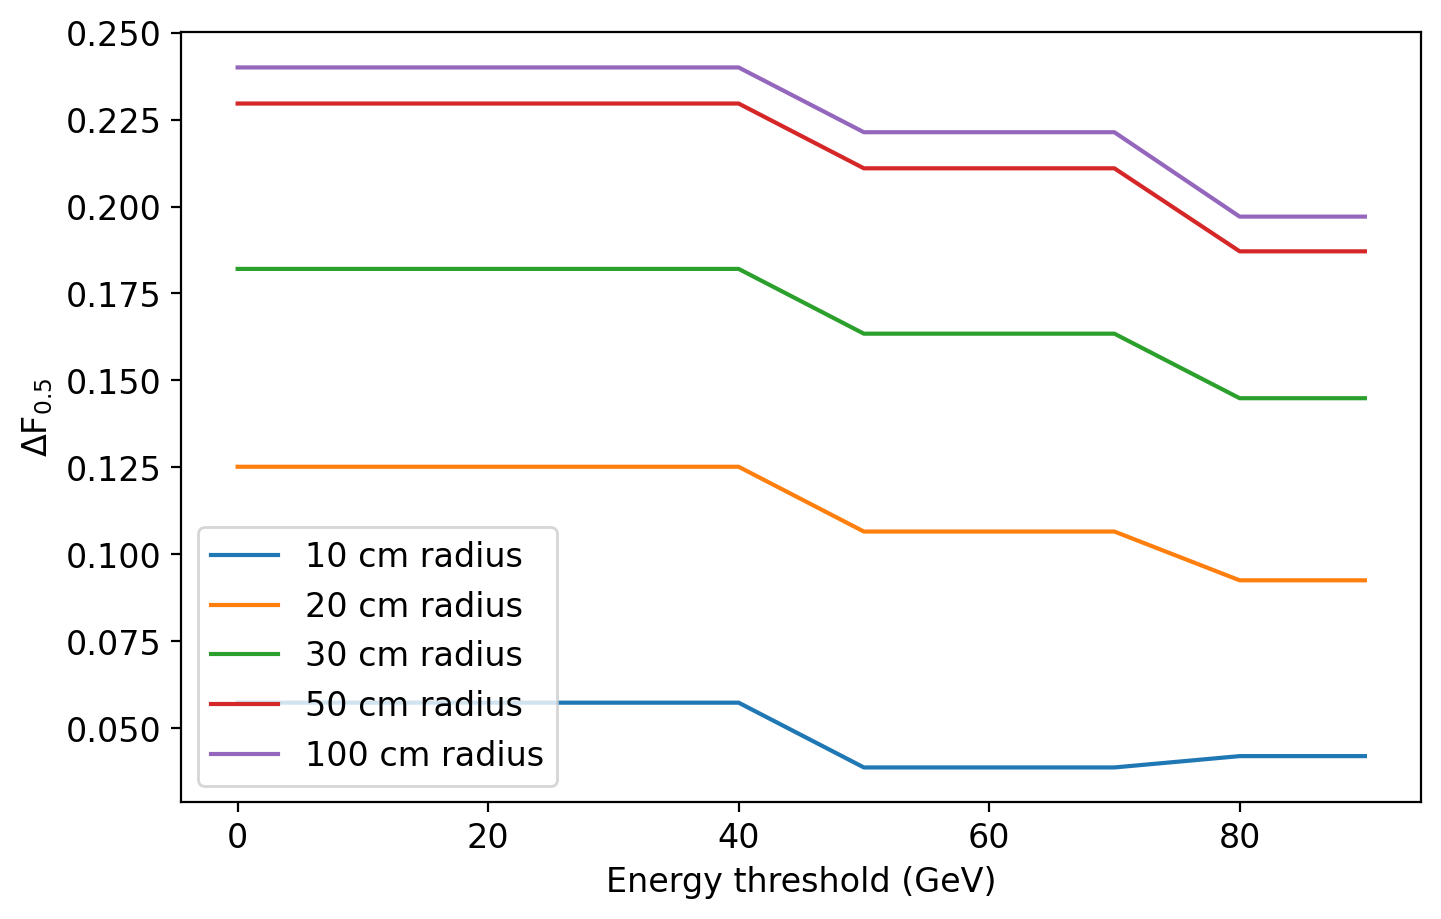

In [14]:
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(111)

for r, res in zip(r_ranges, eth_results):
    ax.plot(eth_ranges, res, label=f"{r} cm radius")

ax.legend()
# ax.set_xlim(0, 100)
ax.set_xlabel("Energy threshold (GeV)")
ax.set_ylabel("$\Delta F_{0.5}$")

# outcome: 10 cm makes sense for PU, not higher

fig.savefig(f'export/{ds_name}-graph-energy-plot.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()